## baseline fit and covariance estimation

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from multiprocessing import Pool
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook, trange

import scripts.plot_tools as pt
import scripts.fit_helpers as fh

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 55707,
  "iopub_port": 46711,
  "stdin_port": 59437,
  "control_port": 37429,
  "hb_port": 44069,
  "ip": "127.0.0.1",
  "key": "6716e453-1edb7548ac02587e73dafe8d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1c7ddba0-a4c4-4633-ad16-05ea10b210ca.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee',  'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
input_dir  = f'local_data/templates/updated_e_sf/'
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)

In [3]:
# prepare Asimov dataset
params = fit_data._parameters
params_pre = fit_data.get_params_init().values
asimov_data = dict()
for category, model_data in fit_data._model_data.items():
    # parse lepton selection and jet category
    cat_split = category.split('_')
    sel = cat_split[0]
    jet_cat = '_'.join(cat_split[1:])
    
    # build prefit expectation from model_tensor
    expected_pre, expected_var = fit_data.mixture_model(params_pre, category)
    expected_test = fit_data.model_sums(sel, jet_cat) # for testing template removal
    
    asimov_data[category] = (expected_pre, np.sqrt(expected_pre))


In [4]:
# initialize veto list
fit_data.veto_list = [
    # baseline
    #'ee_cat_gt2_eq1_b', 'ee_cat_gt2_gt2_b', 
    #'mumu_cat_gt2_eq1_b', 'mumu_cat_gt2_gt2_b', 
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'e4j_cat_gt4_eq1', 'e4j_cat_gt4_gt2'
    #'mu4j_cat_gt4_eq1', 'mu4j_cat_gt4_gt2', 
    'e4j_cat_eq3_gt2', 'mu4j_cat_eq3_gt2',
    
    # e/mu DY CR
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    #'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', 'emu_cat_eq1_eq1_a', 
    
    # e+mu WW
    #'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    #'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    #'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    #'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    #'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]

In [5]:
# fit configuration #

# minimizer options
min_options = dict(#eps=1e-9, 
                   gtol = 1e-2,
                   disp = True
                  )

# configure the objective
mask = fit_data._pmask.copy()
sample = asimov_data
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = True,
               lu_test = 0
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = True,
                   lu_test = 0
                  )


In [6]:
# carry out fit for null hypothesis
#min_options['verbose'] = 2
#result_null = minimize(fobj, params_pre[mask],
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = min_options,
#                       args = ()
#                      )
#
#print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

In [7]:
# carry out fit for null hypothesis
result_null = minimize(fobj, params_pre[mask],
                       jac = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )

print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

         Current function value: 472.730174
         Iterations: 61
         Function evaluations: 121
         Gradient evaluations: 109
 null :  2 472.7301735309337 [10.868 10.868 10.868 67.396]


In [8]:
# carry out fit for alt 1
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
result_alt1 = minimize(fobj, params_pre[mask],
                       jac     = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )
        
print(' alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

         Current function value: 465.011303
         Iterations: 57
         Function evaluations: 178
         Gradient evaluations: 167
 alt. 1:  2 465.01130335819147 [10.858 10.858 11.722 66.563]


In [9]:
# carry out fit for alt 2
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
result_alt2 =  minimize(fobj, params_pre[mask],
                        jac     = fobj_jac,
                        method  = 'BFGS', 
                        options = min_options,
                        #bounds  = bnds,
                       )

print(' alt. 2: ', result_alt2.status, result_alt2.fun, result_alt2.x[:4]*100)

         Current function value: 462.911236
         Iterations: 61
         Function evaluations: 119
         Gradient evaluations: 107
 alt. 2:  2 462.91123557604993 [10.704 10.911 11.7   66.685]


In [10]:
# Wilk's theorem
from scipy.stats import chi2, norm
q1 = 2*(result_null.fun - result_alt1.fun)
z1 = -norm.ppf(chi2.sf(q1, 1))

q2 = 2*(result_null.fun - result_alt2.fun)
z2 = -norm.ppf(chi2.sf(q2, 2))

print(' ', q1, z1, q2, z2)

  15.437740345484485 3.7590840272369923 19.63787590976756 3.870028386296748


In [11]:
# calculate covariance matrix from the inverse of the Hessian of the NLL
p_mle = result_alt2.x
stderr, corr = fh.calculate_covariance(fobj, p_mle)

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)


In [12]:
# plot errors
parameters = fit_data._parameters
parameters['val_fit'] = parameters['val_init']
parameters['err_fit'] = parameters['err_init']
parameters.loc[mask, 'val_fit'] = result_alt2.x
parameters.loc[mask, 'err_fit'] = stderr

# scale branching fraction values
param_mask = np.array(parameters.type == 'poi', dtype=bool)
val_init = parameters.loc[param_mask, 'val_init']
parameters.loc[param_mask, 'err_init'] *= 100/val_init
parameters.loc[param_mask, 'err_fit'] *= 100/val_init

parameters['ratio'] = parameters.err_fit/parameters.err_init

# scale normalization values
param_mask = np.array(parameters.type == 'norm', dtype=bool)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# save fit data
outfile = open('local_data/fit_data_test.pkl', 'wb')
pickle.dump(fit_data, outfile)
outfile.close()

# plot nuisance parameter errors and constraints
parameters.set_index('label')
parameters.to_csv('local_data/pulls.csv')
parameters[['val_init', 'err_init', 'val_fit', 'err_fit']]
#parameters[['err_init', 'err_fit', 'ratio']]#.head(4)

,val_init,err_init,val_fit,err_fit
name,,,,
beta_e,0.108,100.000,0.107,0.970
beta_mu,0.108,100.000,0.109,0.742
beta_tau,0.108,100.000,0.117,2.195
beta_h,0.676,100.000,0.667,0.476
br_tau_e,0.177,0.225,0.177,0.225
br_tau_mu,0.173,0.231,0.173,0.231
br_tau_h,0.650,0.154,0.649,0.154
lumi,1.000,0.025,1.097,0.020
xs_diboson,1.000,0.100,1.012,0.099


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

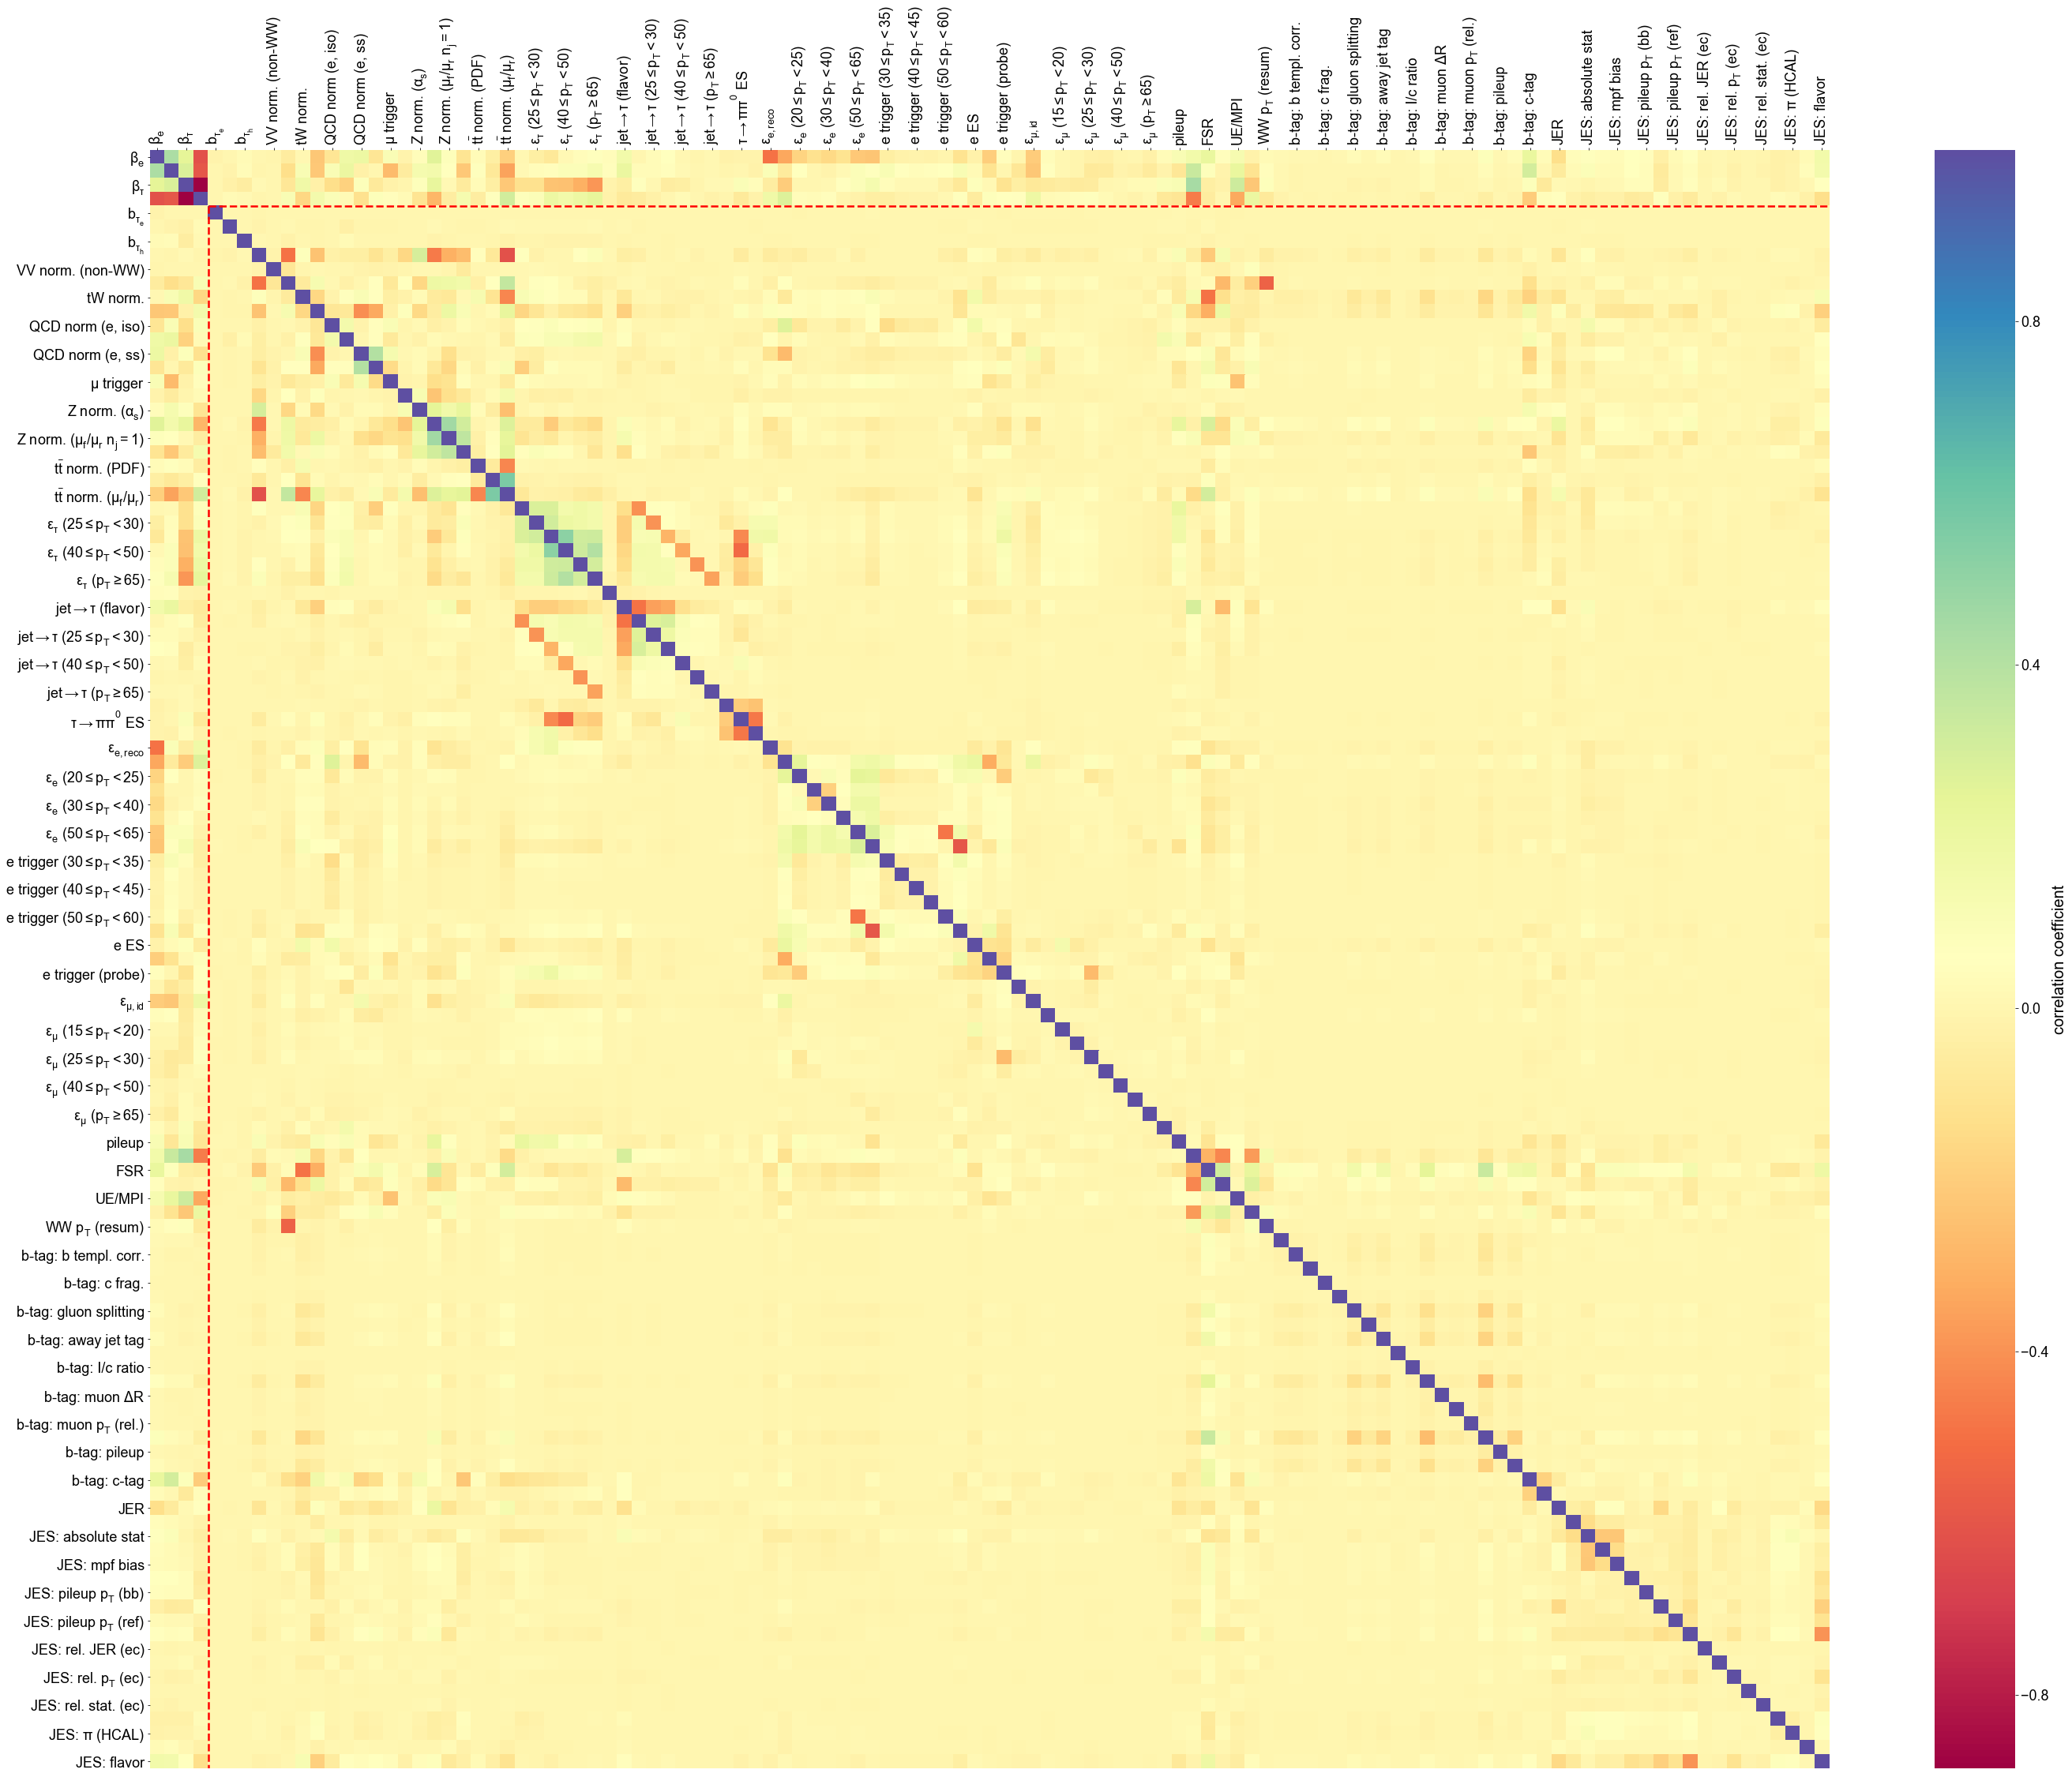

In [13]:
# produce correlation matrix
p_labels = list(params.index)
p_labels_fancy = fit_data._parameters.label[mask]

df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex('local_data/corr_table_full.tex')
df_corr.to_csv('local_data/corr_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(40, 32))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('plots/systematics/correlation_matrix.pdf')
plt.show()

In [14]:
# no MC stat
fobj.keywords['do_bb_lite'] = False
fobj_jac.keywords['do_bb_lite'] = False
err_no_bb, _ = fh.calculate_covariance(fobj, p_mle)

# stat only
mask = fit_data._pmask.copy()
fit_data._pmask[4:] = False
err_stat, _ = fh.calculate_covariance(fobj, p_mle[:4])
err_stat = np.concatenate([err_stat, np.zeros(p_mle.size - 4)])
fit_data._pmask = mask

err_syst = np.sqrt(err_no_bb**2 - err_stat**2)

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)
/home/naodell/work/wbr/analysis/scripts/fit_helpers.py:146: RuntimeWarning: invalid value encountered in sqrt
  sig         = np.sqrt(hinv.diagonal())


In [15]:
print(' stat. error: ', 100*err_stat[:4]/p_mle[:4])
print(' syst. error: ', 100*err_syst[:4]/p_mle[:4])
print(' MC stat. error: ', 100*np.sqrt(stderr[:4]**2 - err_no_bb[:4]**2)/p_mle[:4])
print(' full error: ', 100*stderr[:4]/p_mle[:4])

 stat. error:  [0.111 0.095 0.498 0.082]
 syst. error:  [0.931 0.627 1.556 0.398]
 MC stat. error:  [0.283 0.369 1.198 0.261]
 full error:  [0.979 0.734 2.026 0.483]


## estimating individual systematic contributions

The effect of any individual systematic uncertainty is somewhat complicated by it's mutual covariance with the POI (i.e., the W branching fractions) and any other systematic uncertainty.  To get a rough idea of the percent-wise contribution to the total uncertainty from each individual systematic, I use the following scheme:

   * the fit is carried out as in the nominal case and $\sigma_{0}$ is estimated
   * the fit is carried out for for each of the $n$ nuisance parameters $\sigma_{theta}$
   * the difference between the nominal case and the ``$n-1$" case is calculated,
   * this quantity is normalized to $\sum_{\theta} \sigma_{\theta}^{2}$

In [16]:
# n-1 systematics
pool = Pool(processes=10)
results = []
params_init = fit_data._pval_init[fit_data._pmask]
for i in range(4, len(params_init)):
    mask = np.ones(len(params_init)).astype(bool)
    mask[i] = False
    fobj = partial(reduced_objective, mask=mask, p_init=params_init, do_mc_stat=False)
    res = pool.apply_async(fh.calculate_covariance, args=(fobj, np.delete(params_init, i)))
    results.append(res)
    
pool.close()
pool.join()

output = [r.get() for r in results]

NameError: name 'reduced_objective' is not defined

In [ ]:
# convert to errors
sub_errs = [o[0] for o in output]
errs = np.array([np.concatenate([sub_errs[i-4][:i], [0], sub_errs[i-4][i:]]) for i in range(4, params_init.size)])
errs = err_no_bb**2 - errs**2
errs[errs < 0] = 0

errs = np.sqrt(errs)
errs = np.vstack([errs, err_stat, stderr])

errs = pd.DataFrame(errs, columns=p_labels, index=p_labels[4:] + ['stat', 'total'])
beta_errs = errs.iloc[:,:4].multiply(100)/params_init[:4]

In [ ]:
# print table

#beta_errs.divide(params_init[:4]/100, axis=1).to_latex('local_data/errors.tex')
#beta_errs.divide(params_init[:4]/100, axis=1).to_csv('local_data/errors.csv')
#beta_errs.divide(params_init[:4]/100, axis=1)
beta_errs.to_latex('local_data/summary_errors.tex', escape=False)
beta_errs

In [ ]:
jes_mask = np.array([True if ('jes' in pname and 'btag' not in pname) else False for pname in beta_errs.index])
btag_mask = np.array([True if 'btag' in pname else False for pname in beta_errs.index])
tau_misid_mask = np.array([True if ('misid_tau' in pname and pname not in ['misid_tau_e', 'misid_tau_h']) else False for pname in beta_errs.index])

btag_errs = beta_errs[btag_mask]
jes_errs = beta_errs[jes_mask]
tau_misid_errs = beta_errs[tau_misid_mask]

summary_errs = beta_errs[~btag_mask&~jes_mask&~tau_misid_mask].copy()
summary_errs.index = [fit_data._parameters.loc[p].label if p in fit_data._parameters.index else p for p in summary_errs.index]
summary_errs.loc['b-tag',:] = np.sqrt(np.sum(btag_errs**2))
summary_errs.loc['JES',:]  = np.sqrt(np.sum(jes_errs**2))
summary_errs.loc[r'$\sf jet\rightarrow\tau$',:]  = np.sqrt(np.sum(tau_misid_errs**2))

summary_errs = summary_errs.divide(params_init[:4]/100, axis=1)
summary_errs.to_latex('local_data/summary_errors.tex', escape=False)
summary_errs.to_csv('local_data/summary_errors.csv')
summary_errs